# Load Data

In [1]:
import pickle
import os
from tqdm import tqdm
import numpy as np

directory = 'data/train'

length_list = []
valence_values=[]

recordings = []

for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.pkl'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            if data['valence'] != 2.333:# and len(data['audio_data']) < 91000:
                length_list.append(len(data['audio_data']))
                valence_values.append(data['valence'])
                recordings.append(data['audio_data'])

valence_values = np.array(valence_values)


100%|██████████| 10557/10557 [00:47<00:00, 220.64it/s]


In [2]:
valennce_dist ={}
for i in valence_values:
    if i in valennce_dist:
        valennce_dist[i] += 1
    else:
        valennce_dist[i] = 1


valennce_dist


{1.25: 140,
 3.5: 1194,
 3.25: 1299,
 3.75: 989,
 2.0: 528,
 2.75: 1031,
 2.25: 694,
 3.0: 1063,
 4.25: 613,
 1.0: 114,
 1.5: 229,
 1.75: 408,
 4.75: 151,
 4.0: 801,
 2.5: 907,
 5.0: 28,
 4.5: 367}

In [3]:
# Calculate the maximum length
max_length = max(length_list)
print(max_length)
max_length=50000

# Adjust the recordings to have the same length
adjusted_recordings = []
for recording in recordings:
    # Repeat the array until it reaches or exceeds the maximum length
    repeated_recording = np.tile(recording, (max_length // len(recording) + 1))[:max_length]
    adjusted_recordings.append(repeated_recording)

valence_values = np.array(valence_values)
len(adjusted_recordings), adjusted_recordings[0].shape



174625


(10556, (50000,))

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


############################################################################################################
# Pad the recordings to have the same length
max_length = max(len(array) for array in recordings)  # Find the maximum length

# # Pad each array to have the maximum length
# padded_arrays = np.array([np.pad(array, (0, max_length - len(array)), mode='constant') for array in recordings])


############################################################################################################
# Split the data and labels into training and testing sets
X_train, X_test_help, y_train, y_test_help = train_test_split(adjusted_recordings, valence_values, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test_help, y_test_help, test_size=0.5, random_state=42)



############################################################################################################
# Create a DataLoader for the training set, test set, and validation set

batch_size = 256  # You can adjust the batch size depending on your system's capability

# Convert input data and labels to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Use float32 for labels

# Create a dataset from tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

############################################################################################################
# Repeat the same process for the test set

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



############################################################################################################
# Repeat the same process for the validation set
X_validation_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_validation_tensor = torch.tensor(y_val, dtype=torch.float32)

validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)




C:\Users\20211922\AppData\Local\Temp\ipykernel_7772\735191982.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features


In [5]:
import matplotlib.pyplot as plt

def calculate_label_distribution(labels_tensor):
    label_dist = {}
    for label in labels_tensor:
        label = label.item()  # Convert tensor to int
        if label in label_dist:
            label_dist[label] += 1
        else:
            label_dist[label] = 1
    return label_dist

train_labels = train_loader.dataset.tensors[1]

train_valence_dist = calculate_label_distribution(train_labels)
print(train_valence_dist)


{3.0: 623, 2.75: 616, 2.5: 535, 3.25: 783, 4.25: 363, 3.5: 743, 3.75: 589, 2.25: 420, 1.5: 142, 4.0: 489, 1.75: 245, 1.0: 74, 2.0: 318, 4.5: 211, 4.75: 88, 1.25: 76, 5.0: 18}


# Augment Data

In [6]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, RoomSimulator, Aliasing, HighPassFilter, LowPassFilter,ApplyImpulseResponse
import numpy as np
import torch
import sounddevice as sd
import random


def draw_augmentations(text,amount,fs=12000):
    
    augmentGaussian = Compose([
        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=1),
    ]) #0.001, 0.015

    augmentPitchShift = Compose([
        PitchShift(min_semitones=-4, max_semitones=4, p=1),
    ]) #-4, 4

    # augmentRoomSimulator = Compose([
    #     RoomSimulator(p=1)
    # ])

    augmentAliasing = Compose([
        Aliasing(min_sample_rate=8000, max_sample_rate=30000,p=1)
    ]) #8000, 30000

    augmentHPF = Compose([
        HighPassFilter(min_cutoff_freq=15, max_cutoff_freq=2400,p=1)
        ]) #15, 2400

    augmentedLPF = Compose([
        LowPassFilter(p=1)
    ])


    list_of_augmentations = [ augmentGaussian, augmentPitchShift, augmentAliasing, augmentHPF, augmentedLPF]

    functions = random.sample(list_of_augmentations, amount,)
    for i in functions:
        # print(i.__name__)
        text = i(text, sample_rate=fs)
    # sd.play(text, fs)
    return text


In [7]:

waveforms = train_loader.dataset.tensors[0].numpy().squeeze()  # Convert tensor to NumPy array
labels = train_loader.dataset.tensors[1].numpy().squeeze()  # Convert tensor to NumPy array


# Create a dictionary to hold the data categorized by labels
label_dict = {}

# Iterate through each label and corresponding waveform
for waveform, label in zip(waveforms, labels):
    if label not in label_dict:
        label_dict[label] = []
    label_dict[label].append(waveform)


In [8]:
from tqdm import tqdm
#
amount_of_samples = 300
# def train_balancer(train_valence_dist):
#     train_balanced = {}
#     for label in train_valence_dist.keys():
#         train_balanced[label] = []
#     for label in tqdm(train_valence_dist.keys()):
#         if train_valence_dist[label] < amount_of_samples:
#             for recording in range(len(label_dict[label])):
#                 train_balanced[label].append(label_dict[label][recording])
#             for _ in range(amount_of_samples - len(label_dict[label])):
#                 choose_func_amount = random.randint(1, 3)
#                 choose_index = random.randint(0, len(label_dict[label])-1)
#                 train_balanced[label].append(draw_augmentations(label_dict[label][choose_index],choose_func_amount))
#         else:
#             indices = random.sample(range(len(label_dict[label])), amount_of_samples)
#             for index in indices:
#                 train_balanced[label].append(label_dict[label][index])
#     return train_balanced

def train_balancer(train_valence_dist):
    train_balanced = {}
    for label in train_valence_dist.keys():
        train_balanced[label] = []
    for label in tqdm(train_valence_dist.keys()):
        for recording in range(len(label_dict[label])):
            train_balanced[label].append(label_dict[label][recording])
        if len(label_dict[label]) < 200:
            amount = 200
        else:
            amount = len(label_dict[label])
        for _ in range(amount*2):
            choose_func_amount = random.randint(1, 3)
            choose_index = random.randint(0, len(label_dict[label])-1)
            train_balanced[label].append(draw_augmentations(label_dict[label][choose_index],choose_func_amount))

    return train_balanced


train_balanced = train_balancer(train_valence_dist= train_valence_dist)
print(train_balanced.keys())
print([len(x) for x in train_balanced.values()])
        

100%|██████████| 17/17 [02:56<00:00, 10.39s/it]

dict_keys([3.0, 2.75, 2.5, 3.25, 4.25, 3.5, 3.75, 2.25, 1.5, 4.0, 1.75, 1.0, 2.0, 4.5, 4.75, 1.25, 5.0])
[1869, 1848, 1605, 2349, 1089, 2229, 1767, 1260, 542, 1467, 735, 474, 954, 633, 488, 476, 418]


In [9]:
def array_to_hashable(arr):
    return hash(arr.tobytes())

for arrays in train_balanced.keys():
    print("Label: ", arrays)
    # Convert each array to a hashable type
    unique_hashes = set(array_to_hashable(arr) for arr in train_balanced[arrays])

    # The number of unique arrays
    num_unique_arrays = len(unique_hashes)
    #print("Number of unique arrays for : ", num_unique_arrays)

    

Label:  3.0
Label:  2.75
Label:  2.5
Label:  3.25
Label:  4.25
Label:  3.5
Label:  3.75
Label:  2.25
Label:  1.5
Label:  4.0
Label:  1.75
Label:  1.0
Label:  2.0
Label:  4.5
Label:  4.75
Label:  1.25
Label:  5.0


In [10]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np



test_dict = train_balanced

# Flatten the dictionary into lists of samples and labels
X_train = []
y_train = []
for label, arrays in tqdm(test_dict.items()):
    for array in arrays:
        X_train.append(array)
        y_train.append(label)  # Adjust how labels are encoded as needed


# Convert lists to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Adjust the type depending on how you encode labels

# Apply standard scaling to the input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_tensor.squeeze().numpy())  # Fit scaler and transform the data

# Convert scaled data back to tensor
X_train_scaled_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)


# Create a dataset from tensors
train_dataset = TensorDataset(X_train_scaled_tensor, y_train_tensor)

# Define the batch size
batch_size = 256  # Adjust batch size based on your system capability

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(train_loader.dataset.tensors[0].shape)

100%|██████████| 17/17 [00:00<00:00, 1887.78it/s]


torch.Size([20203, 1, 50000])


# **MODEL**

In [11]:
def round_to_nearest_quarter(number):
    # Assuming 'number' could be a numpy array with a single value
    if isinstance(number, np.ndarray) and number.size == 1:
        number = number.item()  # Convert single-item array to scalar
    
    # Ensure the number is within the 1 to 5 range before processing
    number = np.clip(number, 1, 5)
    # Scale number to shift quarters to whole numbers, round, and rescale
    rounded_number = np.round(number * 4) / 4
    # Clip again to ensure no out-of-range values after rounding
    rounded_number = np.clip(rounded_number, 1, 5)
    return str(rounded_number)

In [12]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torchaudio.transforms as transforms


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()



        # Set random seed for reproducibility
        torch.manual_seed(42)


        self.mfcc_transform = transforms.MFCC(
            sample_rate=44100,      ## 44.1 kHz
            n_mfcc=24              ## Created channels
        )

        self.layers = nn.ModuleList()
        
        self.layers.append(nn.BatchNorm1d(24)) #24
        conv1 = nn.Conv1d(in_channels=24, out_channels=24, kernel_size=7, padding=1) #24,48
        nn.init.kaiming_normal_(conv1.weight, nonlinearity='relu')
        self.layers.append(conv1)
        self.layers.append(nn.BatchNorm1d(24)) #48
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3)) 
        self.layers.append(nn.Dropout(0.25))

        conv2 = nn.Conv1d(in_channels=24, out_channels=48, kernel_size=7, padding=1) #48,48
        nn.init.kaiming_normal_(conv2.weight, nonlinearity='relu')
        self.layers.append(conv2)
        self.layers.append(nn.BatchNorm1d(48)) #48
        self.layers.append(nn.ReLU())


        conv3 = nn.Conv1d(in_channels=48, out_channels=96, kernel_size=7, padding=1) #48,12
        nn.init.kaiming_normal_(conv3.weight, nonlinearity='relu')
        self.layers.append(conv3)
        self.layers.append(nn.BatchNorm1d(96)) #12
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=4)) #3
        self.layers.append(nn.Dropout(0.25))
#
        conv4 = nn.Conv1d(in_channels=96, out_channels=192, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv4.weight, nonlinearity='relu')
        self.layers.append(conv4)
        self.layers.append(nn.BatchNorm1d(192))
        self.layers.append(nn.ReLU())

        conv5 = nn.Conv1d(in_channels=192, out_channels=192, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv5.weight, nonlinearity='relu')
        self.layers.append(conv5)
        self.layers.append(nn.BatchNorm1d(192))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=5)) #3
        self.layers.append(nn.Dropout(0.25))

#
        self.layers.append(nn.Flatten())

        linear1= nn.Linear(384,256) #(564, 256)
        nn.init.kaiming_normal_(linear1.weight, nonlinearity='relu')
        self.layers.append(linear1)
        self.layers.append(nn.ReLU())
        
        linear2 = nn.Linear(256, 1)
        nn.init.kaiming_normal_(linear2.weight, nonlinearity='relu')
        self.layers.append(linear2)


# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()



#         # Set random seed for reproducibility
#         torch.manual_seed(42)


#         self.mfcc_transform = transforms.MFCC(
#             sample_rate=44100,      ## 44.1 kHz
#             n_mfcc=40              ## Created channels
#         )

#         self.layers = nn.ModuleList()
        
#         self.layers.append(nn.BatchNorm1d(40))
#         conv1 = nn.Conv1d(in_channels=40, out_channels=20, kernel_size=10, padding=1)
#         nn.init.kaiming_normal_(conv1.weight, nonlinearity='relu')
#         self.layers.append(conv1)
#         self.layers.append(nn.BatchNorm1d(20))
#         self.layers.append(nn.ReLU())
#         self.layers.append(nn.MaxPool1d(kernel_size=2))
#         self.layers.append(nn.Dropout(0.25))

#         conv2 = nn.Conv1d(in_channels=20, out_channels=20, kernel_size=10, padding=1)
#         nn.init.kaiming_normal_(conv2.weight, nonlinearity='relu')
#         self.layers.append(conv2)
#         self.layers.append(nn.BatchNorm1d(20))
#         self.layers.append(nn.ReLU())
#         self.layers.append(nn.MaxPool1d(kernel_size=2))
       
#         conv3 = nn.Conv1d(in_channels=20, out_channels=10, kernel_size=10, padding=1)
#         nn.init.kaiming_normal_(conv3.weight, nonlinearity='relu')
#         self.layers.append(conv3)
#         self.layers.append(nn.BatchNorm1d(10))
#         self.layers.append(nn.ReLU())
#         self.layers.append(nn.MaxPool1d(kernel_size=2))
#         self.layers.append(nn.Dropout(0.25))

#         self.layers.append(nn.Flatten())

#         linear1= nn.Linear(250,256)
#         nn.init.kaiming_normal_(linear1.weight, nonlinearity='relu')
#         self.layers.append(linear1)
#         self.layers.append(nn.ReLU())
        
#         linear2 = nn.Linear(256, 1)
#         nn.init.kaiming_normal_(linear2.weight, nonlinearity='relu')
#         self.layers.append(linear2)

    
    def forward(self, x):
        x = self.mfcc_transform(x)
        x = x.squeeze(1)
        for layer in self.layers:
            x = layer(x)
            #print(x.shape)
        return x.view(-1)


### CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Training Cycle

def train_model(MLP_model, optimizer, num_epochs):
        criterion = nn.MSELoss()
        #criterion = nn.L1Loss()
        # Training loop
        for epoch in tqdm(range(num_epochs)):
            total_loss = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = MLP_model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute the loss
                loss.backward()  # Backward pass

                optimizer.step()

                # Store the loss. loss.item() gets the value in a tensor. This only works for scalars.
                total_loss += loss.item()
        
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')
            if epoch > 1:
                print(evaluate_model(MLP_model, validation_loader,conf=False))
            print('--------------------------------------------------')
        print(evaluate_model(MLP_model, train_loader,conf=True))


def evaluate_model(MLP_model, test_loader,conf=False):
    k = 0
    with torch.no_grad():
        ### Calculate MSE 
        predictions = []
        actuals = []
        actuals_for_cm = []
        rounded_predictions = []
        for inputs, labels in test_loader:
            while k < 1:
                print(type(inputs))
                k += 1
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = MLP_model(inputs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
            actuals_for_cm.extend([str(label) for label in labels.cpu().numpy()])
            rounded_predictions.extend([str(round_to_nearest_quarter(output)) for output in outputs.cpu().numpy()])

        predictions = np.array(predictions)
        actuals = np.array(actuals)
        mse = np.mean((predictions - actuals) ** 2)
        mae = np.mean(np.abs(predictions - actuals))
        print(f'Mean Squared Error: {mse:.4f} and Mean Absolute Error: {mae:.4f}')

        # for i in range(10):
        #     print(f"Predictions: {predictions[i]}")
        #     print(f"Actuals: {actuals[i]}")
        #     print(f"Rounded Predictions: {rounded_predictions[i]}")
        
        ##################
        # Confusion Matrix
        ##################
        if conf:
            ### Confusion Matrix
            cm = confusion_matrix(actuals_for_cm, rounded_predictions)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(actuals), yticklabels=np.unique(actuals))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()
            ### Accuracy
            accuracy = np.trace(cm) / np.sum(cm)
            print(f'Accuracy: {accuracy:.4f}')
    
def get_predictions(MLP_model, test_loader,conf=False):
    with torch.no_grad():
        ### Calculate MSE 
        predictions = []
        actuals = []
        actuals_for_cm = []
        rounded_predictions = []
        for inputs in test_loader:
            inputs= inputs.to(device)
            outputs = MLP_model(inputs)
            predictions.extend(outputs.cpu().numpy())
            #actuals.extend(labels.cpu().numpy())
            #actuals_for_cm.extend([str(label) for label in labels.cpu().numpy()])
            rounded_predictions.extend([str(round_to_nearest_quarter(output)) for output in outputs.cpu().numpy()])

        predictions = np.array(predictions)

    return predictions



c:\Users\20211922\Documents\DeepL\DL_ASSIGNMENT\.venv\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
  2%|▏         | 1/50 [00:14<11:59, 14.67s/it]

Epoch [1/50], Loss: 1.9431
--------------------------------------------------


  4%|▍         | 2/50 [00:21<08:07, 10.17s/it]

Epoch [2/50], Loss: 0.9073
--------------------------------------------------
Epoch [3/50], Loss: 0.8155
<class 'torch.Tensor'>


  6%|▌         | 3/50 [00:29<07:14,  9.25s/it]

Mean Squared Error: 0.6807 and Mean Absolute Error: 0.6742
None
--------------------------------------------------
Epoch [4/50], Loss: 0.7756
<class 'torch.Tensor'>


  8%|▊         | 4/50 [00:37<06:40,  8.71s/it]

Mean Squared Error: 0.6719 and Mean Absolute Error: 0.6667
None
--------------------------------------------------
Epoch [5/50], Loss: 0.7285
<class 'torch.Tensor'>


 10%|█         | 5/50 [00:45<06:10,  8.24s/it]

Mean Squared Error: 0.6047 and Mean Absolute Error: 0.6263
None
--------------------------------------------------
Epoch [6/50], Loss: 0.7000
<class 'torch.Tensor'>


 12%|█▏        | 6/50 [00:52<05:50,  7.96s/it]

Mean Squared Error: 0.6096 and Mean Absolute Error: 0.6297
None
--------------------------------------------------
Epoch [7/50], Loss: 0.6747
<class 'torch.Tensor'>


 14%|█▍        | 7/50 [00:59<05:30,  7.69s/it]

Mean Squared Error: 0.5937 and Mean Absolute Error: 0.6188
None
--------------------------------------------------
Epoch [8/50], Loss: 0.6572
<class 'torch.Tensor'>


 16%|█▌        | 8/50 [01:06<05:16,  7.52s/it]

Mean Squared Error: 0.5364 and Mean Absolute Error: 0.5883
None
--------------------------------------------------
Epoch [9/50], Loss: 0.6426
<class 'torch.Tensor'>


 18%|█▊        | 9/50 [01:14<05:06,  7.48s/it]

Mean Squared Error: 0.5712 and Mean Absolute Error: 0.6075
None
--------------------------------------------------
Epoch [10/50], Loss: 0.6324
<class 'torch.Tensor'>


 20%|██        | 10/50 [01:21<04:56,  7.42s/it]

Mean Squared Error: 0.5354 and Mean Absolute Error: 0.5844
None
--------------------------------------------------
Epoch [11/50], Loss: 0.6159
<class 'torch.Tensor'>


 22%|██▏       | 11/50 [01:28<04:48,  7.41s/it]

Mean Squared Error: 0.5404 and Mean Absolute Error: 0.5883
None
--------------------------------------------------
Epoch [12/50], Loss: 0.6021
<class 'torch.Tensor'>


 24%|██▍       | 12/50 [01:36<04:44,  7.48s/it]

Mean Squared Error: 0.5166 and Mean Absolute Error: 0.5812
None
--------------------------------------------------
Epoch [13/50], Loss: 0.5910
<class 'torch.Tensor'>


 26%|██▌       | 13/50 [01:43<04:34,  7.41s/it]

Mean Squared Error: 0.5424 and Mean Absolute Error: 0.5889
None
--------------------------------------------------
Epoch [14/50], Loss: 0.5842
<class 'torch.Tensor'>


 28%|██▊       | 14/50 [01:51<04:26,  7.40s/it]

Mean Squared Error: 0.5088 and Mean Absolute Error: 0.5749
None
--------------------------------------------------
Epoch [15/50], Loss: 0.5778
<class 'torch.Tensor'>


 30%|███       | 15/50 [01:58<04:19,  7.42s/it]

Mean Squared Error: 0.5289 and Mean Absolute Error: 0.5818
None
--------------------------------------------------
Epoch [16/50], Loss: 0.5746
<class 'torch.Tensor'>


 32%|███▏      | 16/50 [02:06<04:13,  7.46s/it]

Mean Squared Error: 0.5036 and Mean Absolute Error: 0.5733
None
--------------------------------------------------
Epoch [17/50], Loss: 0.5639
<class 'torch.Tensor'>


 34%|███▍      | 17/50 [02:13<04:05,  7.44s/it]

Mean Squared Error: 0.5227 and Mean Absolute Error: 0.5767
None
--------------------------------------------------
Epoch [18/50], Loss: 0.5581
<class 'torch.Tensor'>


 36%|███▌      | 18/50 [02:20<03:56,  7.40s/it]

Mean Squared Error: 0.4968 and Mean Absolute Error: 0.5679
None
--------------------------------------------------
Epoch [19/50], Loss: 0.5547
<class 'torch.Tensor'>


 38%|███▊      | 19/50 [02:28<03:48,  7.38s/it]

Mean Squared Error: 0.5110 and Mean Absolute Error: 0.5752
None
--------------------------------------------------
Epoch [20/50], Loss: 0.5464
<class 'torch.Tensor'>


 40%|████      | 20/50 [02:35<03:41,  7.39s/it]

Mean Squared Error: 0.5112 and Mean Absolute Error: 0.5722
None
--------------------------------------------------
Epoch [21/50], Loss: 0.5409
<class 'torch.Tensor'>


 42%|████▏     | 21/50 [02:43<03:36,  7.46s/it]

Mean Squared Error: 0.4832 and Mean Absolute Error: 0.5578
None
--------------------------------------------------
Epoch [22/50], Loss: 0.5360
<class 'torch.Tensor'>


 44%|████▍     | 22/50 [02:50<03:28,  7.44s/it]

Mean Squared Error: 0.4953 and Mean Absolute Error: 0.5684
None
--------------------------------------------------
Epoch [23/50], Loss: 0.5316
<class 'torch.Tensor'>


 46%|████▌     | 23/50 [02:58<03:22,  7.50s/it]

Mean Squared Error: 0.4793 and Mean Absolute Error: 0.5603
None
--------------------------------------------------
Epoch [24/50], Loss: 0.5245
<class 'torch.Tensor'>


 48%|████▊     | 24/50 [03:05<03:16,  7.55s/it]

Mean Squared Error: 0.5049 and Mean Absolute Error: 0.5721
None
--------------------------------------------------
Epoch [25/50], Loss: 0.5251
<class 'torch.Tensor'>


 50%|█████     | 25/50 [03:13<03:09,  7.57s/it]

Mean Squared Error: 0.4853 and Mean Absolute Error: 0.5597
None
--------------------------------------------------
Epoch [26/50], Loss: 0.5222
<class 'torch.Tensor'>


 52%|█████▏    | 26/50 [03:21<03:02,  7.59s/it]

Mean Squared Error: 0.4801 and Mean Absolute Error: 0.5563
None
--------------------------------------------------
Epoch [27/50], Loss: 0.5151
<class 'torch.Tensor'>


 54%|█████▍    | 27/50 [03:28<02:54,  7.60s/it]

Mean Squared Error: 0.4951 and Mean Absolute Error: 0.5619
None
--------------------------------------------------
Epoch [28/50], Loss: 0.5077
<class 'torch.Tensor'>


 56%|█████▌    | 28/50 [03:36<02:45,  7.52s/it]

Mean Squared Error: 0.4860 and Mean Absolute Error: 0.5624
None
--------------------------------------------------
Epoch [29/50], Loss: 0.5071
<class 'torch.Tensor'>


 58%|█████▊    | 29/50 [03:43<02:36,  7.45s/it]

Mean Squared Error: 0.4870 and Mean Absolute Error: 0.5632
None
--------------------------------------------------
Epoch [30/50], Loss: 0.5008
<class 'torch.Tensor'>


 60%|██████    | 30/50 [03:50<02:28,  7.44s/it]

Mean Squared Error: 0.4804 and Mean Absolute Error: 0.5588
None
--------------------------------------------------
Epoch [31/50], Loss: 0.5002
<class 'torch.Tensor'>


 62%|██████▏   | 31/50 [03:58<02:21,  7.45s/it]

Mean Squared Error: 0.4739 and Mean Absolute Error: 0.5523
None
--------------------------------------------------
Epoch [32/50], Loss: 0.4970
<class 'torch.Tensor'>


 64%|██████▍   | 32/50 [04:05<02:13,  7.44s/it]

Mean Squared Error: 0.4921 and Mean Absolute Error: 0.5656
None
--------------------------------------------------
Epoch [33/50], Loss: 0.4915
<class 'torch.Tensor'>


 66%|██████▌   | 33/50 [04:13<02:05,  7.39s/it]

Mean Squared Error: 0.4981 and Mean Absolute Error: 0.5656
None
--------------------------------------------------
Epoch [34/50], Loss: 0.4909
<class 'torch.Tensor'>


 68%|██████▊   | 34/50 [04:20<01:58,  7.41s/it]

Mean Squared Error: 0.4731 and Mean Absolute Error: 0.5537
None
--------------------------------------------------
Epoch [35/50], Loss: 0.4827
<class 'torch.Tensor'>


 70%|███████   | 35/50 [04:28<01:51,  7.44s/it]

Mean Squared Error: 0.4710 and Mean Absolute Error: 0.5500
None
--------------------------------------------------
Epoch [36/50], Loss: 0.4824
<class 'torch.Tensor'>


 72%|███████▏  | 36/50 [04:35<01:44,  7.45s/it]

Mean Squared Error: 0.4736 and Mean Absolute Error: 0.5541
None
--------------------------------------------------
Epoch [37/50], Loss: 0.4815
<class 'torch.Tensor'>


 74%|███████▍  | 37/50 [04:43<01:37,  7.49s/it]

Mean Squared Error: 0.4943 and Mean Absolute Error: 0.5661
None
--------------------------------------------------
Epoch [38/50], Loss: 0.4811
<class 'torch.Tensor'>


 76%|███████▌  | 38/50 [04:50<01:30,  7.51s/it]

Mean Squared Error: 0.4862 and Mean Absolute Error: 0.5572
None
--------------------------------------------------
Epoch [39/50], Loss: 0.4761
<class 'torch.Tensor'>


 78%|███████▊  | 39/50 [04:58<01:22,  7.51s/it]

Mean Squared Error: 0.4811 and Mean Absolute Error: 0.5562
None
--------------------------------------------------
Epoch [40/50], Loss: 0.4758
<class 'torch.Tensor'>


 80%|████████  | 40/50 [05:05<01:15,  7.54s/it]

Mean Squared Error: 0.4857 and Mean Absolute Error: 0.5607
None
--------------------------------------------------
Epoch [41/50], Loss: 0.4705
<class 'torch.Tensor'>


 82%|████████▏ | 41/50 [05:13<01:07,  7.53s/it]

Mean Squared Error: 0.4788 and Mean Absolute Error: 0.5525
None
--------------------------------------------------
Epoch [42/50], Loss: 0.4654
<class 'torch.Tensor'>


 84%|████████▍ | 42/50 [05:20<01:00,  7.55s/it]

Mean Squared Error: 0.4900 and Mean Absolute Error: 0.5655
None
--------------------------------------------------
Epoch [43/50], Loss: 0.4623
<class 'torch.Tensor'>


 86%|████████▌ | 43/50 [05:28<00:52,  7.46s/it]

Mean Squared Error: 0.4782 and Mean Absolute Error: 0.5531
None
--------------------------------------------------
Epoch [44/50], Loss: 0.4640
<class 'torch.Tensor'>


 88%|████████▊ | 44/50 [05:35<00:44,  7.39s/it]

Mean Squared Error: 0.4735 and Mean Absolute Error: 0.5514
None
--------------------------------------------------
Epoch [45/50], Loss: 0.4607
<class 'torch.Tensor'>


 90%|█████████ | 45/50 [05:42<00:36,  7.35s/it]

Mean Squared Error: 0.4814 and Mean Absolute Error: 0.5546
None
--------------------------------------------------
Epoch [46/50], Loss: 0.4601
<class 'torch.Tensor'>


 92%|█████████▏| 46/50 [05:49<00:29,  7.33s/it]

Mean Squared Error: 0.4612 and Mean Absolute Error: 0.5428
None
--------------------------------------------------
Epoch [47/50], Loss: 0.4560
<class 'torch.Tensor'>


 94%|█████████▍| 47/50 [05:56<00:21,  7.27s/it]

Mean Squared Error: 0.4934 and Mean Absolute Error: 0.5611
None
--------------------------------------------------
Epoch [48/50], Loss: 0.4513
<class 'torch.Tensor'>


 96%|█████████▌| 48/50 [06:04<00:14,  7.32s/it]

Mean Squared Error: 0.4791 and Mean Absolute Error: 0.5518
None
--------------------------------------------------
Epoch [49/50], Loss: 0.4520
<class 'torch.Tensor'>


 98%|█████████▊| 49/50 [06:11<00:07,  7.34s/it]

Mean Squared Error: 0.4862 and Mean Absolute Error: 0.5546
None
--------------------------------------------------
Epoch [50/50], Loss: 0.4506
<class 'torch.Tensor'>


100%|██████████| 50/50 [06:19<00:00,  7.58s/it]

Mean Squared Error: 0.4943 and Mean Absolute Error: 0.5630
None
--------------------------------------------------
<class 'torch.Tensor'>


Mean Squared Error: 0.4454 and Mean Absolute Error: 0.5317


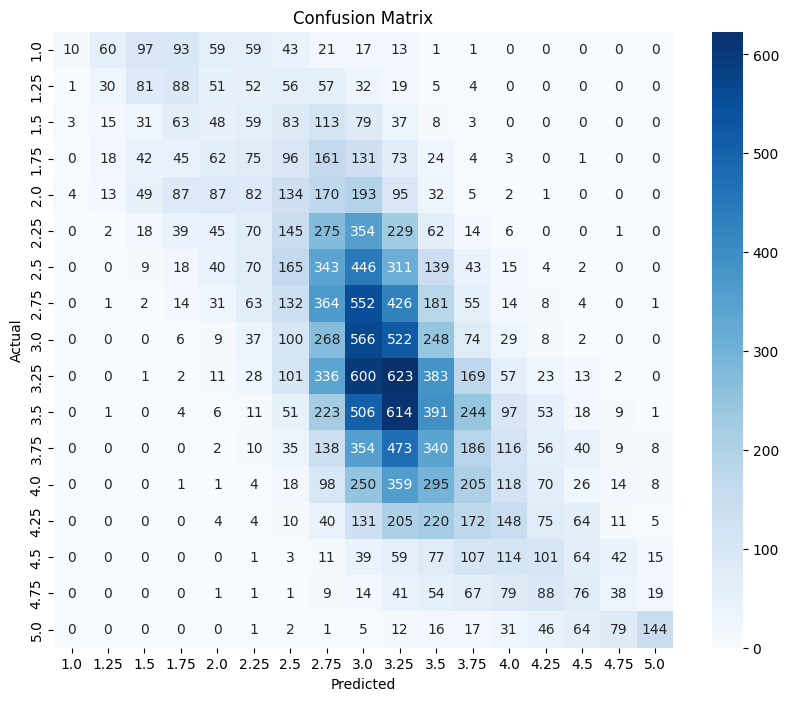

Accuracy: 0.1488
None


In [13]:
modelCNN = CNN().to(device)
optimizer = optim.Adagrad(modelCNN.parameters(), lr=0.001, weight_decay=0.0001)
#optimizer = optim.Adadelta(modelCNN.parameters(), lr=0.001, weight_decay=0.0001)
#optimizer = optim.SGD(modelCNN.parameters(), lr=0.0005, momentum=0.01, weight_decay =0.0001, nesterov=True)
#lr = 0.001
train_model(modelCNN, optimizer, num_epochs=50)

<class 'torch.Tensor'>
Mean Squared Error: 0.5101 and Mean Absolute Error: 0.5697


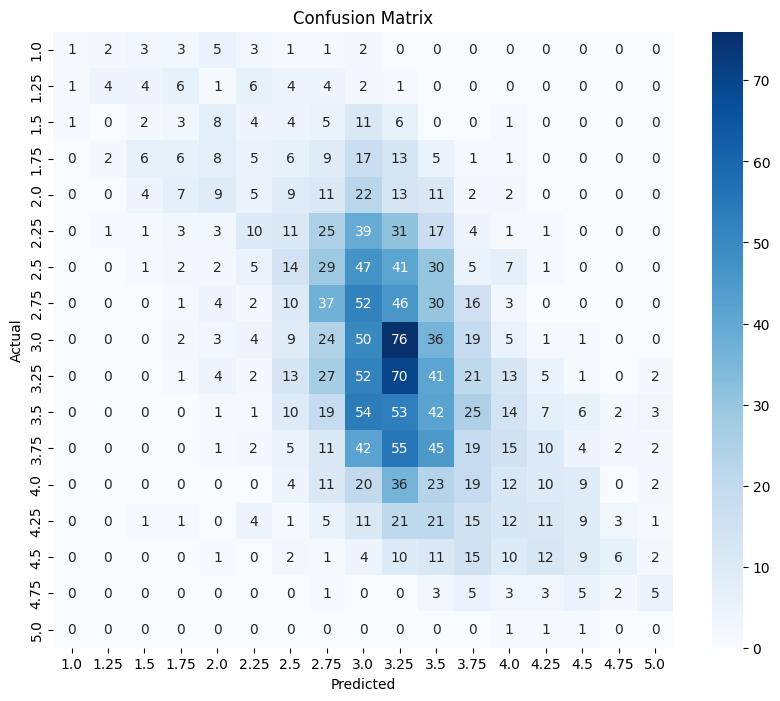

Accuracy: 0.1411


In [14]:
evaluate_model(modelCNN, test_loader,conf=True)

In [15]:
# # Define the directory containing test data
# directory = 'data/test'

# # Load test data
# test_recordings = []
# test_filenames = []
# lenght_list = []

# for filename in tqdm(os.listdir(directory)):
#     if filename.endswith('.pkl'):
#         file_path = os.path.join(directory, filename)
#         with open(file_path, 'rb') as file:
#             data = pickle.load(file)
#             length_list.append(len(data['audio_data']))
#             test_recordings.append(data['audio_data'])
#             test_filenames.append(filename)

# # Calculate the maximum length
# max_length = max(length_list)

# # Adjust the recordings to have the same length
# adjusted_recordings = []
# for recording in test_recordings:
#     # Repeat the array until it reaches or exceeds the maximum length
#     repeated_recording = np.tile(recording, (max_length // len(recording) + 1))[:max_length]
#     adjusted_recordings.append(repeated_recording)


# batch_size = 256  # You can adjust the batch size depending on your system's capability

# # Convert input data and labels to tensors
# X_train_tensor = torch.tensor(adjusted_recordings, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features

# # Create a dataset from tensors
# train_dataset = TensorDataset(X_train_tensor)

# # Create a DataLoader
# final_test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



In [16]:
# def get_predictions(MLP_model, test_loader, conf=False):
#     with torch.no_grad():
#         predictions = []
#         for inputs in test_loader:  # Iterate over batches from the DataLoader
#             print(inputs)
#             inputs = test_loader.dataset.tensors[0].numpy().squeeze()
#             print(inputs)
#             print(inputs.shape)
#             outputs = MLP_model(inputs)
#             predictions.extend(outputs.cpu().numpy())
#         return predictions

In [17]:
# ### CUDA
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# predictions = get_predictions(modelCNN, final_test_loader,conf=False)
# # Create DataFrame to store predictions in the required format
# predictions_df = pd.DataFrame({'ID': test_filenames, 'Label': predictions})

# # Save predictions to a CSV file

# predictions_df.to_csv('predictions.csv', index=False)